# Demo of iRF regression

* The following is a demo of the scikit learn iRF code

## Typical Setup


### Import the required dependencies

* In particular `irf_utils` and `irf_jupyter_utils`

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt

from sklearn.datasets import load_breast_cancer, load_boston
from sklearn.model_selection import train_test_split
import numpy as np
from functools import reduce

# Needed for the scikit-learn wrapper function
from irf import irf_utils
from irf.ensemble import RandomForestRegressor
from math import ceil

# Import our custom utilities
from imp import reload
from irf import irf_jupyter_utils
reload(irf_jupyter_utils)

/home/ubuntu/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d


<module 'irf.irf_jupyter_utils' from '/home/ubuntu/github/irf/irf/irf_jupyter_utils.py'>

## Step 1: Fit the Initial Random Forest

* Just fit every feature with equal weights per the usual random forest code e.g. DecisionForestRegressor

In [2]:
from sklearn.model_selection import train_test_split
raw_data = load_boston()

X_train, X_test, y_train, y_test = train_test_split(
    raw_data.data, raw_data.target, train_size=0.5,
    random_state=2018)

# Just fit a simple random forest classifier with 2 decision trees
rf = RandomForestRegressor(
    n_estimators=20, random_state=2019)

# fit the classifier
rf.fit(X=X_train, y=y_train)

/home/ubuntu/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2026: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=20, n_jobs=1,
           oob_score=False, random_state=2019, verbose=0, warm_start=False)

## Check out the data

In [3]:
print("Training feature dimensions", X_train.shape, sep = ":\n")
print("\n")
print("Training outcome dimensions", y_train.shape, sep = ":\n")
print("\n")
print("Test feature dimensions", X_test.shape, sep = ":\n")
print("\n")
print("Test outcome dimensions", y_test.shape, sep = ":\n")
print("\n")
print("first 2 rows of the training set features", X_train[:2], sep = ":\n")
print("\n")
print("first 2 rows of the training set outcomes", y_train[:2], sep = ":\n")

Training feature dimensions:
(253, 13)


Training outcome dimensions:
(253,)


Test feature dimensions:
(253, 13)


Test outcome dimensions:
(253,)


first 2 rows of the training set features:
[[1.7780e-02 9.5000e+01 1.4700e+00 0.0000e+00 4.0300e-01 7.1350e+00
  1.3900e+01 7.6534e+00 3.0000e+00 4.0200e+02 1.7000e+01 3.8430e+02
  4.4500e+00]
 [2.9090e-01 0.0000e+00 2.1890e+01 0.0000e+00 6.2400e-01 6.1740e+00
  9.3600e+01 1.6119e+00 4.0000e+00 4.3700e+02 2.1200e+01 3.8808e+02
  2.4160e+01]]


first 2 rows of the training set outcomes:
[32.9 14. ]


## Step 2: Get all Random Forest and Decision Tree Data

* Extract in a single dictionary the random forest data and for all of it's decision trees
* This is as required for RIT purposes

In [4]:
all_rf_tree_data = irf_utils.get_rf_tree_data(
    rf=rf, X_train=X_train, X_test=X_test, y_test=y_test)

## STEP 3: Get the RIT data and produce RITs

In [5]:
np.random.seed(12)
all_rit_tree_data = irf_utils.get_rit_tree_data(
    all_rf_tree_data=all_rf_tree_data,
    bin_class_type=None,
    M=100,
    max_depth=2,
    noisy_split=False,
    num_splits=2)

# Perform Manual CHECKS on the `irf_utils`
* These should be converted to unit tests and checked with `nosetests -v test_irf_utils.py`

# Step 4: Plot some Data

### List Ranked Feature Importances

In [6]:
# Print the feature ranking
print("Feature ranking:")

feature_importances_rank_idx = all_rf_tree_data['feature_importances_rank_idx']
feature_importances = all_rf_tree_data['feature_importances']

for f in range(X_train.shape[1]):
    print("%d. feature %d (%f)" % (f + 1
                                   , feature_importances_rank_idx[f]
                                   , feature_importances[feature_importances_rank_idx[f]]))

Feature ranking:
1. feature 12 (0.548507)
2. feature 5 (0.253695)
3. feature 7 (0.044783)
4. feature 0 (0.043400)
5. feature 4 (0.041353)
6. feature 10 (0.011835)
7. feature 6 (0.011417)
8. feature 2 (0.011065)
9. feature 11 (0.010984)
10. feature 9 (0.010416)
11. feature 3 (0.008188)
12. feature 8 (0.003720)
13. feature 1 (0.000638)


### Plot Ranked Feature Importances

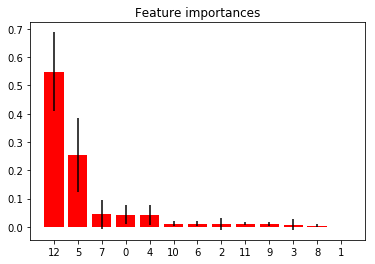

In [7]:
# Plot the feature importances of the forest
feature_importances_std = all_rf_tree_data['feature_importances_std']

plt.figure()
plt.title("Feature importances")
plt.bar(range(X_train.shape[1])
        , feature_importances[feature_importances_rank_idx]
        , color="r"
        , yerr = feature_importances_std[feature_importances_rank_idx], align="center")
plt.xticks(range(X_train.shape[1]), feature_importances_rank_idx)
plt.xlim([-1, X_train.shape[1]])
plt.show()

## Decision Tree 0 (First) - Get output

### Check the output against the decision tree graph

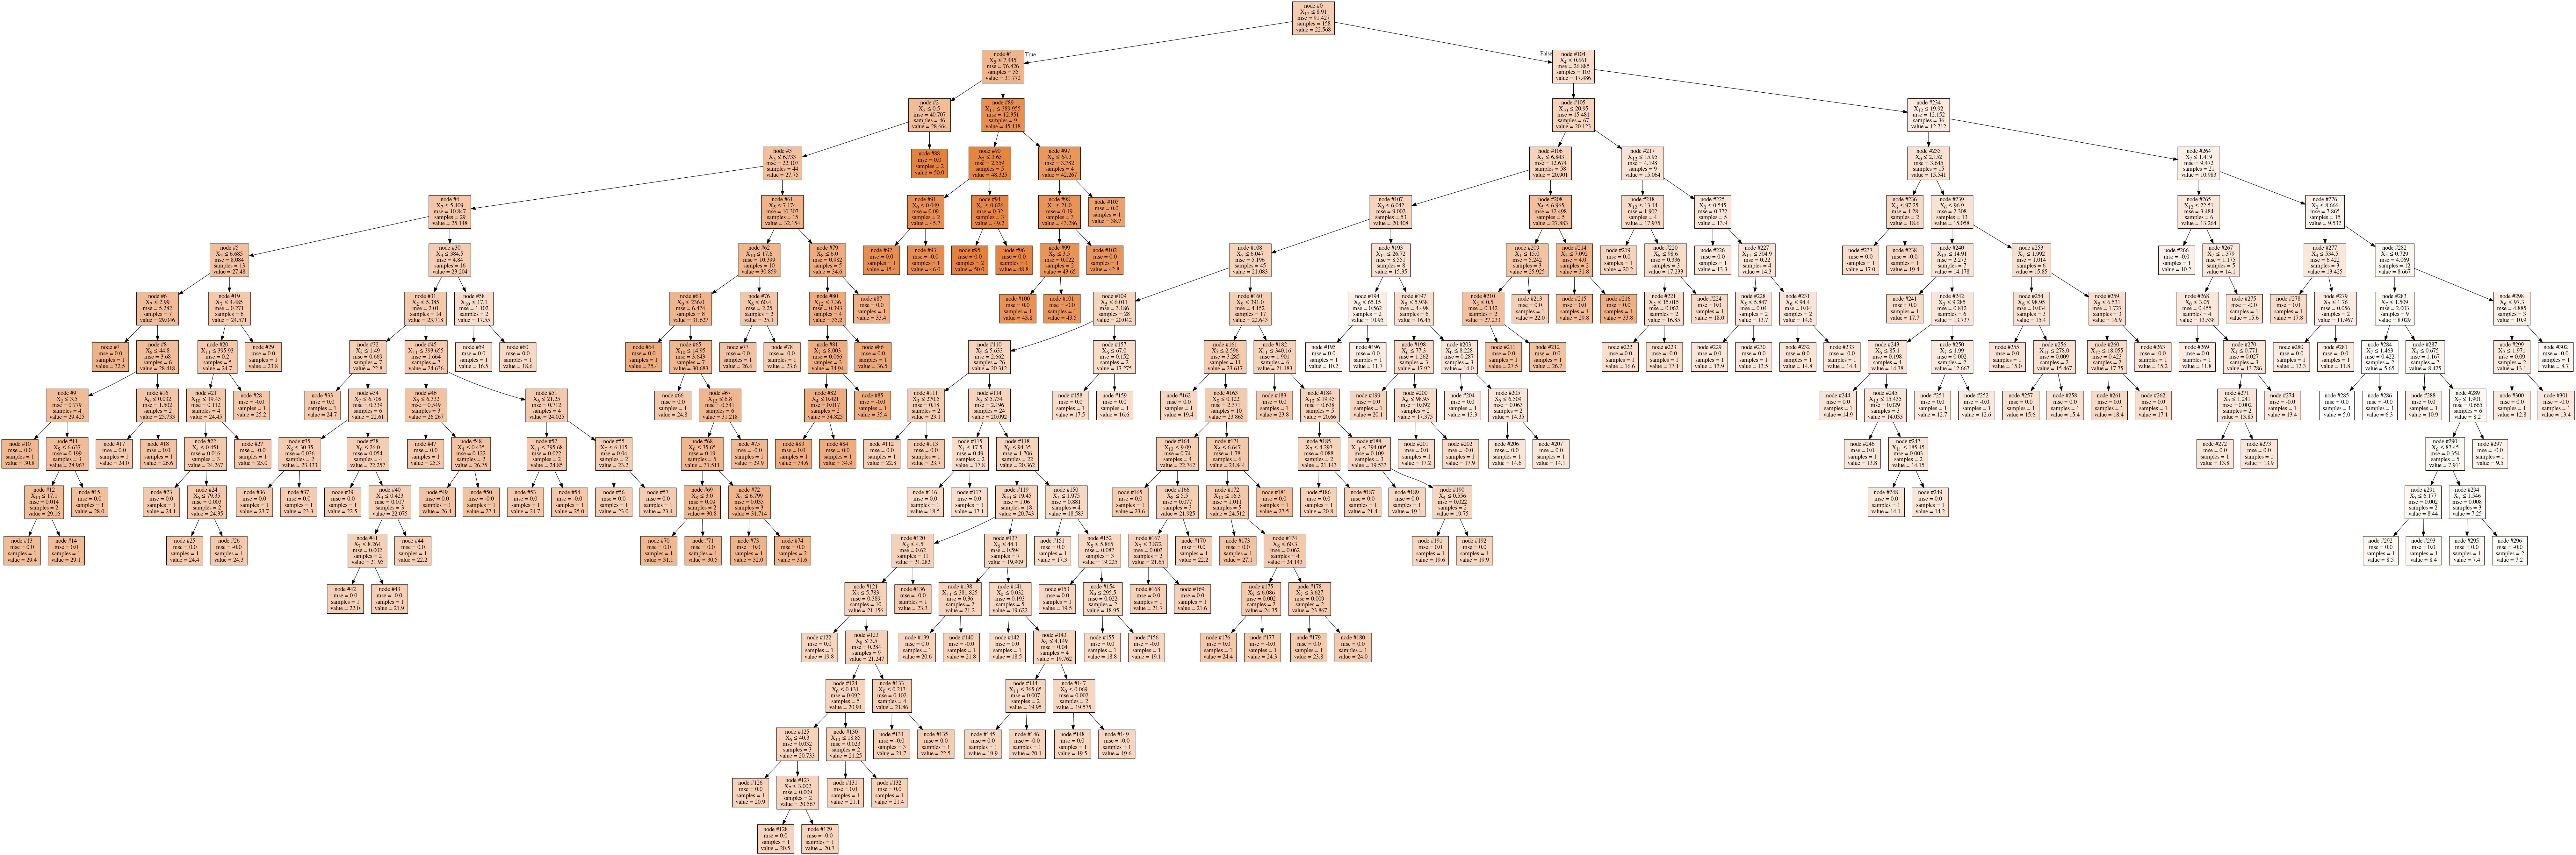

In [8]:
# Now plot the trees individually
irf_jupyter_utils.draw_tree(decision_tree = all_rf_tree_data['rf_obj'].estimators_[0])

## Compare to our dict of extracted data from the tree

In [9]:
#irf_jupyter_utils.pretty_print_dict(inp_dict = all_rf_tree_data['dtree0'])

In [10]:
# Count the number of samples passing through the leaf nodes
sum(all_rf_tree_data['dtree0']['tot_leaf_node_values'])

3256

### Check output against the diagram

In [11]:
#irf_jupyter_utils.pretty_print_dict(inp_dict = all_rf_tree_data['dtree0']['all_leaf_paths_features'])

# Run the iRF function

We will run the iRF with the following **parameters**

#### Data:
* breast cancer binary classification data
* **random state (for reproducibility):** 2018

#### Weighted RFs
* **K:** 5 iterations
* **number of trees:** 20

#### Bootstrap RFs
* **proportion of bootstrap samples:** 20%
* **B:** 30 bootstrap samples
* **number of trees (bootstrap RFs):** 5 iterations

#### RITs (on the bootstrap RFs)
* **M:** 20 RITs per forest
* **filter label type:** 1-class only
* **Max Depth:** 5
* **Noisy Split:** False
* **Number of splits at Node:** 2 splits

# Running the iRF is easy - single function call

* All of the bootstrap, RIT complexity is covered through the key parameters passed through
in the main algorithm (as listed above)
* This function call returns the following data:
    1. all RF weights
    2. all the K RFs that are iterated over
    3. all of the B bootstrap RFs that are run
    4. all the B*M RITs that are run on the bootstrap RFs
    5. the stability score
    
### This is a lot of data returned!

Will be useful when we build the **interface** later

### Let's run it!

In [12]:
all_rf_weights, all_K_iter_rf_data, \
all_rf_bootstrap_output, all_rit_bootstrap_output, \
stability_score = irf_utils.run_iRF(X_train=X_train,
                                    X_test=X_test,
                                    y_train=y_train,
                                    y_test=y_test,
                                    K=5,
                                    rf=RandomForestRegressor(),
                                    B=30,
                                    random_state_classifier=2018,
                                    propn_n_samples=.2,
                                    bin_class_type=None,
                                    M=20,
                                    max_depth=5,
                                    noisy_split=False,
                                    num_splits=2,)

In [13]:
stability_score

{'4_5_6_10_12': 0.03333333333333333,
 '4_5_10_12': 0.16666666666666666,
 '4_5_10': 0.03333333333333333,
 '5_10': 0.06666666666666667,
 '5': 0.9666666666666667,
 '5_12': 1.0,
 '12': 0.9666666666666667,
 '4_5_12': 0.8333333333333334,
 '5_10_12': 0.4666666666666667,
 '0_4_5_10_12': 0.1,
 '0_5_12': 0.9,
 '5_7_12': 0.8666666666666667,
 '0_5_7_10_12': 0.06666666666666667,
 '0_4_5_12': 0.43333333333333335,
 '4_12': 0.5666666666666667,
 '5_7_10_12': 0.1,
 '0_5_6_8_10_11_12': 0.03333333333333333,
 '0_5_10_12': 0.13333333333333333,
 '0_5': 0.3333333333333333,
 '0_5_7': 0.13333333333333333,
 '5_7': 0.43333333333333335,
 '0_7_10_12': 0.03333333333333333,
 '0_5_6_12': 0.2,
 '5_6': 0.1,
 '0_6_12': 0.13333333333333333,
 '0_12': 0.6,
 '5_6_12': 0.5,
 '6_12': 0.36666666666666664,
 '0_4_6_10_12': 0.03333333333333333,
 '4_6_12': 0.06666666666666667,
 '11_12': 0.3,
 '4_11_12': 0.06666666666666667,
 '2_5_12': 0.13333333333333333,
 '2_12': 0.13333333333333333,
 '4_5': 0.3333333333333333,
 '5_6_7_11_12': 0.0

# Examine the stability scores

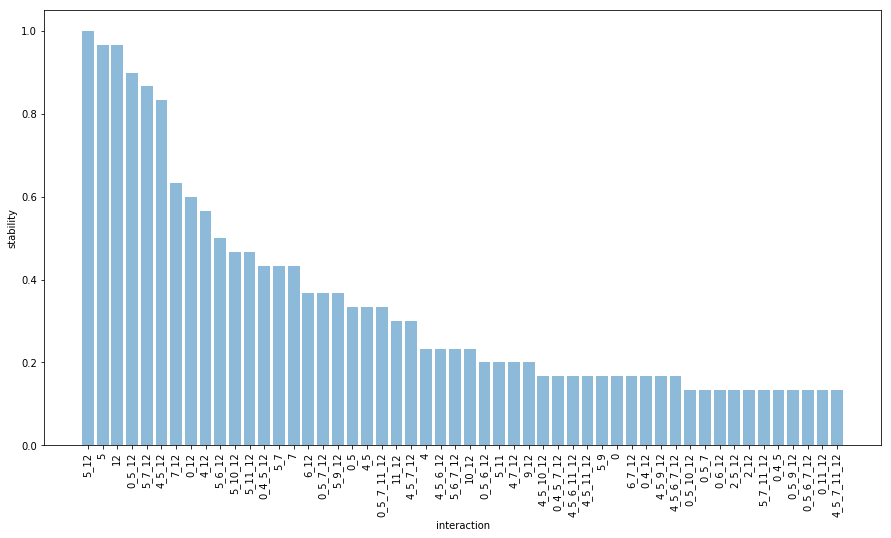

In [14]:
irf_jupyter_utils._get_histogram({key: value for key, value in stability_score.items() if value > 0.1}, sort = True)

That's interesting - feature 22, 27, 20, 23 keep popping up!

We should probably look at the feature importances to understand if there is a useful correlation

# Examine feature importances
In particular, let us see how they change over the K iterations of random forest

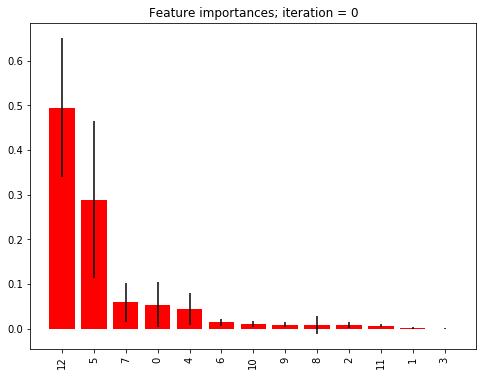

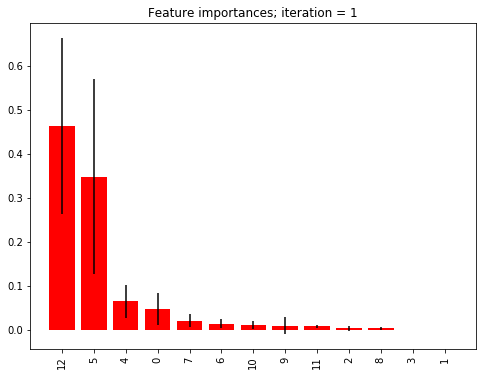

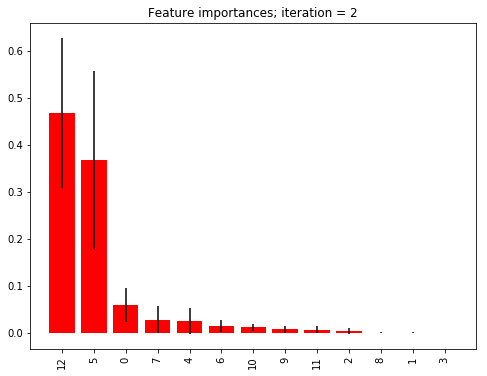

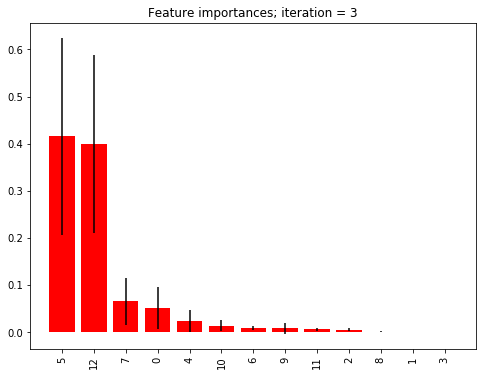

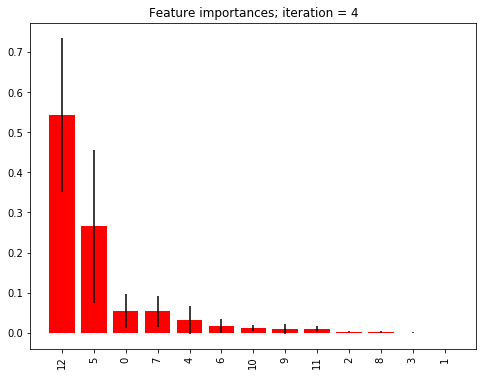

In [15]:
for k in range(5): 
    
    iteration = "rf_iter{}".format(k)
    
    feature_importances_std = all_K_iter_rf_data[iteration]['feature_importances_std']
    feature_importances_rank_idx = all_K_iter_rf_data[iteration]['feature_importances_rank_idx']
    feature_importances = all_K_iter_rf_data[iteration]['feature_importances']

    plt.figure(figsize=(8, 6))
    title = "Feature importances; iteration = {}".format(k)
    plt.title(title)
    plt.bar(range(X_train.shape[1])
            , feature_importances[feature_importances_rank_idx]
            , color="r"
            , yerr = feature_importances_std[feature_importances_rank_idx], align="center")
    plt.xticks(range(X_train.shape[1]), feature_importances_rank_idx, rotation='vertical')
    plt.xlim([-1, X_train.shape[1]])
    plt.show()   

## Some Observations
* Note that after 5 iterations, the most important features were found to be 12, 5, 0, 7.
* Now also recall that the most stable interactions were found to be '5_12', '0_5_12', '5_7_12', '4_5_12'
* Given the overlap between these two plots, the results are not unreasonable here. 

# Explore iRF Data Further

## We can look at the decision paths of the Kth RF

Let's look at the final iteration RF - the key validation metrics

In [16]:
irf_jupyter_utils.pretty_print_dict(all_K_iter_rf_data['rf_iter4']['rf_validation_metrics'])

{'mae_loss': 1.7899999999999991, 'mse_loss': 12.890367193675885}


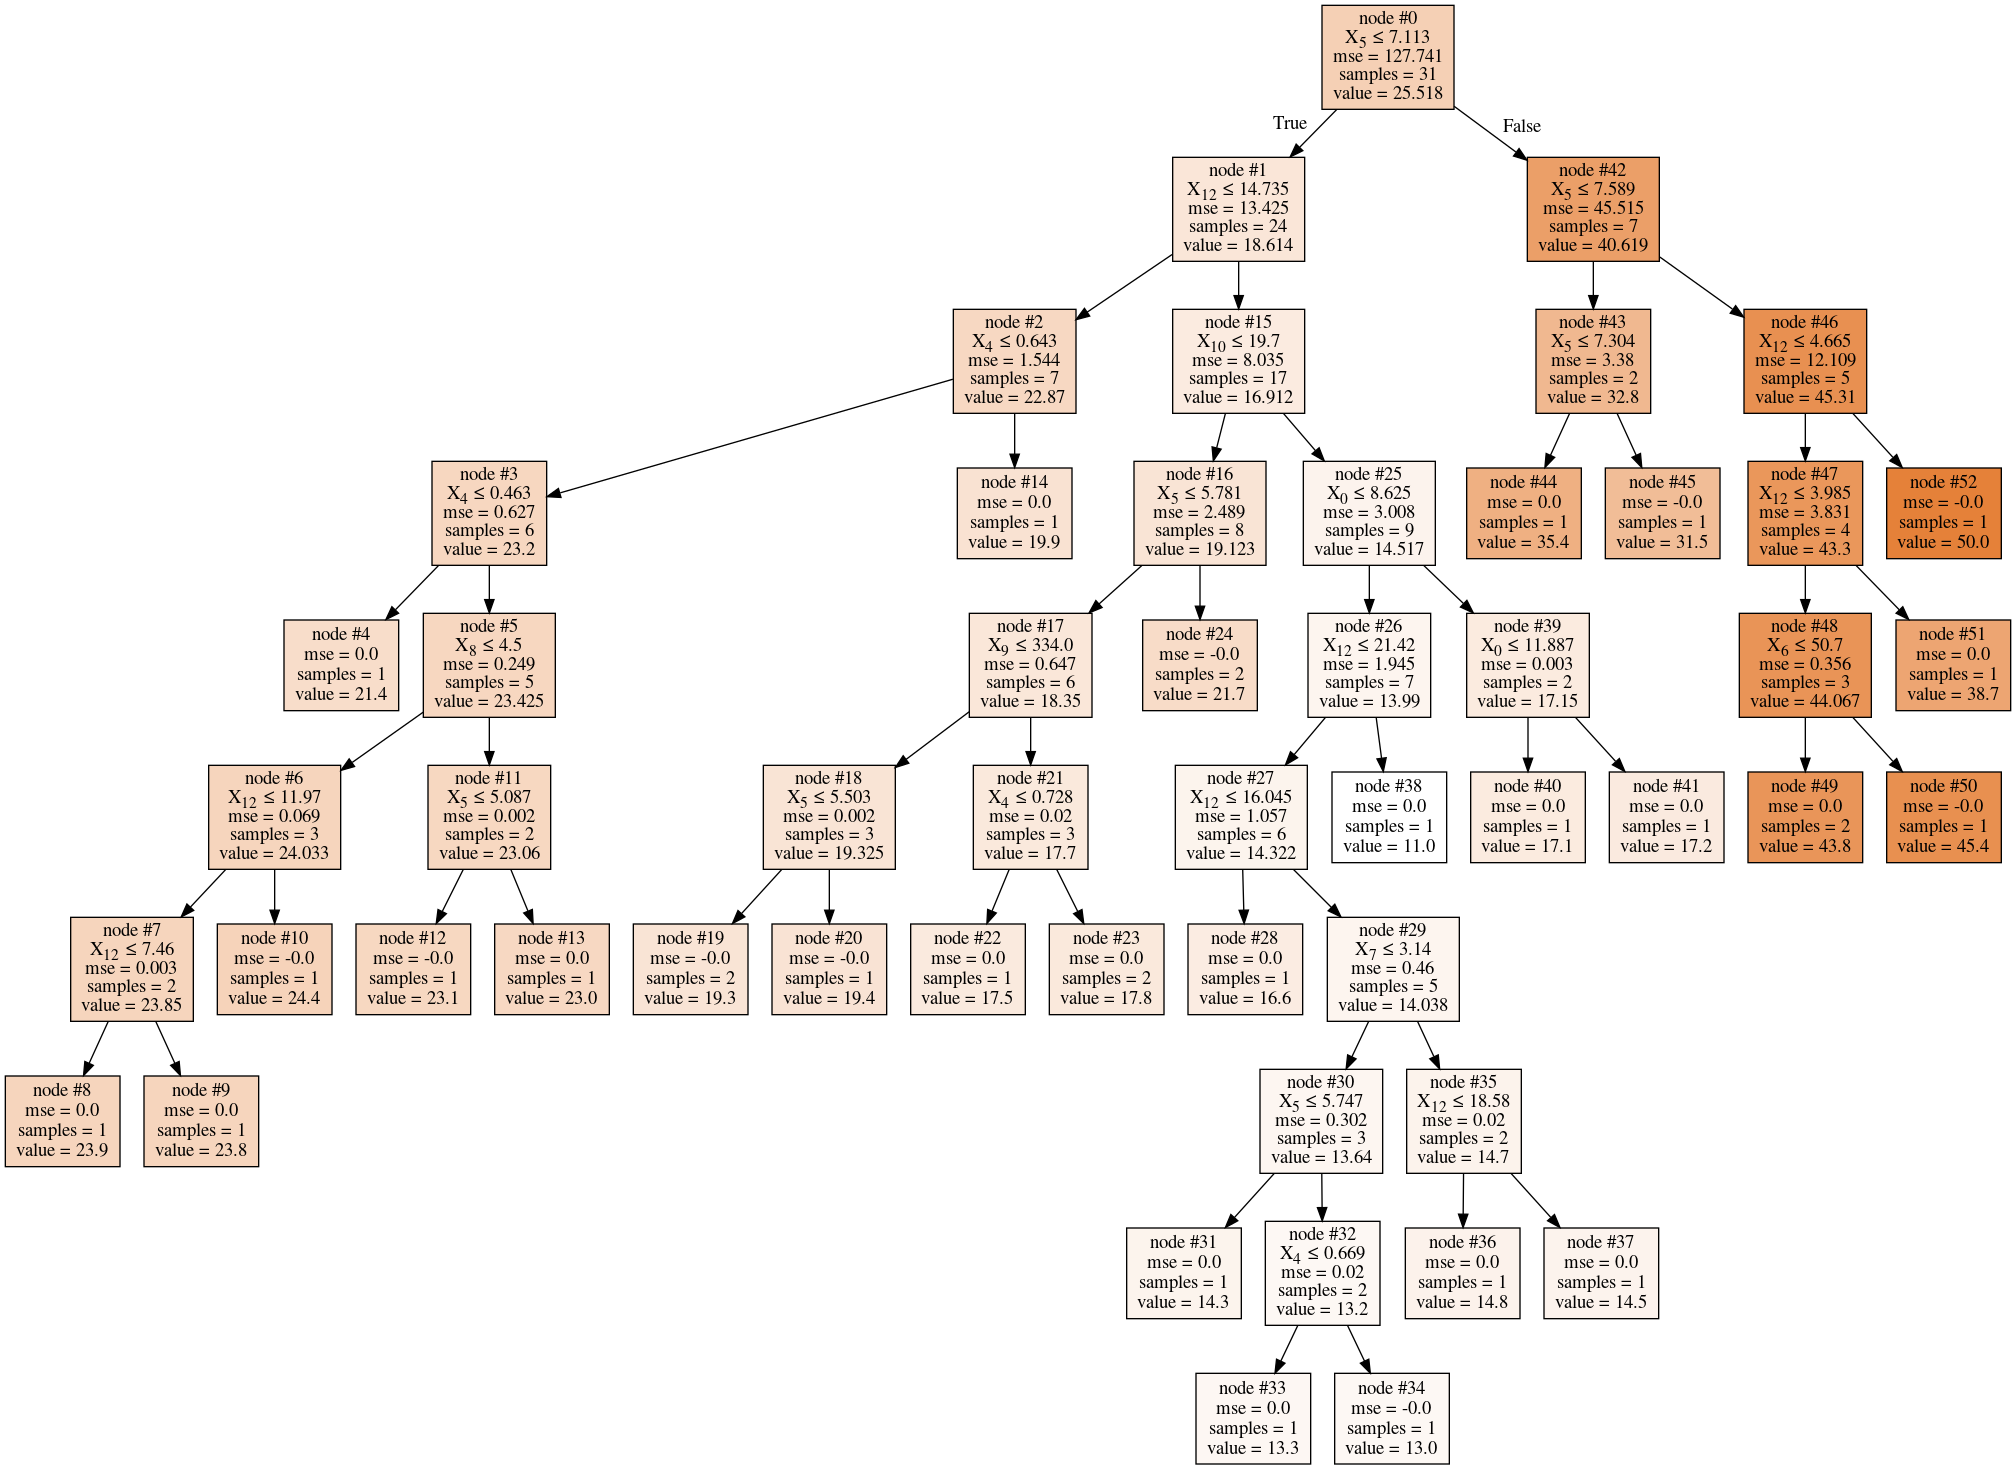

In [17]:
# Now plot the trees individually
irf_jupyter_utils.draw_tree(decision_tree = all_K_iter_rf_data['rf_iter4']['rf_obj'].estimators_[0])

### We can get this data quite easily in a convenient format

In [18]:
irf_jupyter_utils.pretty_print_dict(
    all_K_iter_rf_data['rf_iter4']['dtree0']['all_leaf_paths_features'])

[   array([12,  5,  0,  5,  5, 10, 12, 12, 10]),
    array([12,  5,  0,  5,  5, 10, 12, 12, 10]),
    array([12,  5,  0,  5,  5, 10, 12, 12, 11]),
    array([12,  5,  0,  5,  5, 10, 12, 12, 11,  9,  5]),
    array([12,  5,  0,  5,  5, 10, 12, 12, 11,  9,  5]),
    array([12,  5,  0,  5,  5, 10, 12, 12, 11,  9, 12]),
    array([12,  5,  0,  5,  5, 10, 12, 12, 11,  9, 12, 12]),
    array([12,  5,  0,  5,  5, 10, 12, 12, 11,  9, 12, 12]),
    array([12,  5,  0,  5,  5, 10, 12]),
    array([12,  5,  0,  5,  5, 10, 12]),
    array([12,  5,  0,  5,  5, 10, 12,  5,  7]),
    array([12,  5,  0,  5,  5, 10, 12,  5,  7]),
    array([12,  5,  0,  5,  5, 10, 12,  5]),
    array([12,  5,  0,  5,  5,  6,  6, 10,  5,  5]),
    array([12,  5,  0,  5,  5,  6,  6, 10,  5,  5]),
    array([12,  5,  0,  5,  5,  6,  6, 10,  5, 12]),
    array([12,  5,  0,  5,  5,  6,  6, 10,  5, 12]),
    array([12,  5,  0,  5,  5,  6,  6, 10,  5, 12]),
    array([12,  5,  0,  5,  5,  6,  6, 10,  5, 12]),
    array([12,  5

This checks nicely against the plotted diagram above.

In fact - we can go further and plot some interesting data from the Decision Trees
- This can help us understand variable interactions better

In [19]:
irf_jupyter_utils.pretty_print_dict(
    all_K_iter_rf_data['rf_iter4']['dtree0']['all_leaf_node_values'])

[   array([[22]]),
    array([[23]]),
    array([[27]]),
    array([[25]]),
    array([[25]]),
    array([[24]]),
    array([[24]]),
    array([[24]]),
    array([[29]]),
    array([[20]]),
    array([[23]]),
    array([[23]]),
    array([[22]]),
    array([[29]]),
    array([[29]]),
    array([[30]]),
    array([[31]]),
    array([[28]]),
    array([[28]]),
    array([[26]]),
    array([[35]]),
    array([[32]]),
    array([[26]]),
    array([[24]]),
    array([[23]]),
    array([[24]]),
    array([[26]]),
    array([[32]]),
    array([[29]]),
    array([[33]]),
    array([[32]]),
    array([[31]]),
    array([[34]]),
    array([[33]]),
    array([[36]]),
    array([[33]]),
    array([[37]]),
    array([[36]]),
    array([[23]]),
    array([[50]]),
    array([[50]]),
    array([[37]]),
    array([[38]]),
    array([[41]]),
    array([[42]]),
    array([[48]]),
    array([[50]]),
    array([[19]]),
    array([[18]]),
    array([[18]]),
    array([[20]]),
    array([[20]]),
    array([[

## We can also look at the frequency that a feature appears along a decision path

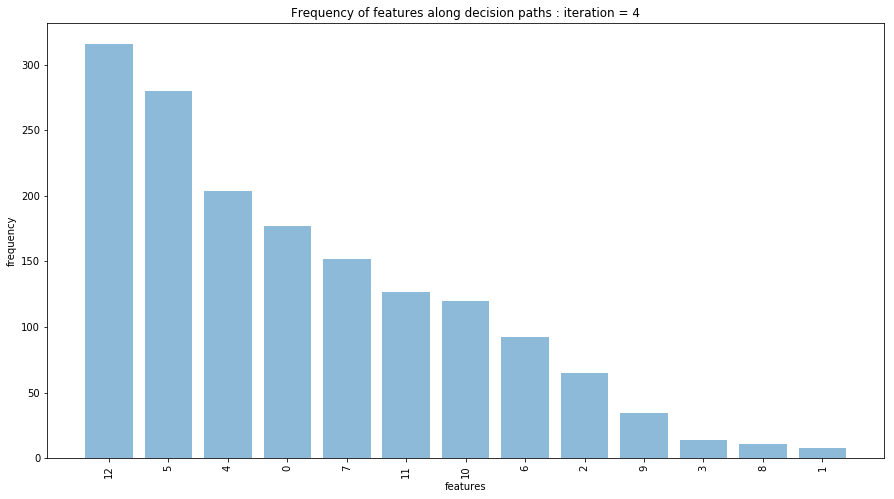

In [20]:
irf_jupyter_utils._hist_features(all_K_iter_rf_data['rf_iter4'], n_estimators = 2, \
                         title = 'Frequency of features along decision paths : iteration = 4')

The most common features that appeared were 27,22,23, and 7. This matches well with the feature importance plot above. 

# Run some Sanity Checks

## Run iRF for just 1 iteration - should be the uniform sampling version

This is just a sanity check: the feature importances from iRF after 1 iteration should match the feature importance from running a standard RF

In [21]:
all_K_iter_rf_data.keys()
print(all_K_iter_rf_data['rf_iter0']['feature_importances'])

[5.41042089e-02 1.12769929e-03 7.90596680e-03 3.22434787e-04
 4.48608520e-02 2.89110738e-01 1.40953468e-02 5.93153887e-02
 7.97781001e-03 9.43674539e-03 9.94142690e-03 6.91524422e-03
 4.94886138e-01]


Compare to the original single fitted random forest

In [22]:
rf = RandomForestRegressor(n_estimators=20, random_state=2018)
rf.fit(X=X_train, y=y_train)
print(rf.feature_importances_)

[5.05845179e-02 1.26970530e-03 6.08126095e-03 3.45598375e-04
 5.59065675e-02 3.15501437e-01 1.69053594e-02 3.87702570e-02
 6.63571111e-03 1.30865713e-02 1.11840449e-02 8.04202169e-03
 4.75686948e-01]


And they match perfectly as expected. 

## End Wrapper test